# Sound Speed (L3)

Un segnale audio può essere convertito in segnale in tensione analogico. 

In [2]:
import numpy as np
from dataclasses import dataclass
import matplotlib.pyplot as plt
from utils import Data, FFTData, initialize_plot
initialize_plot()
import mplhep as hep


import glob

files = sorted(glob.glob('data/*.lvm'))

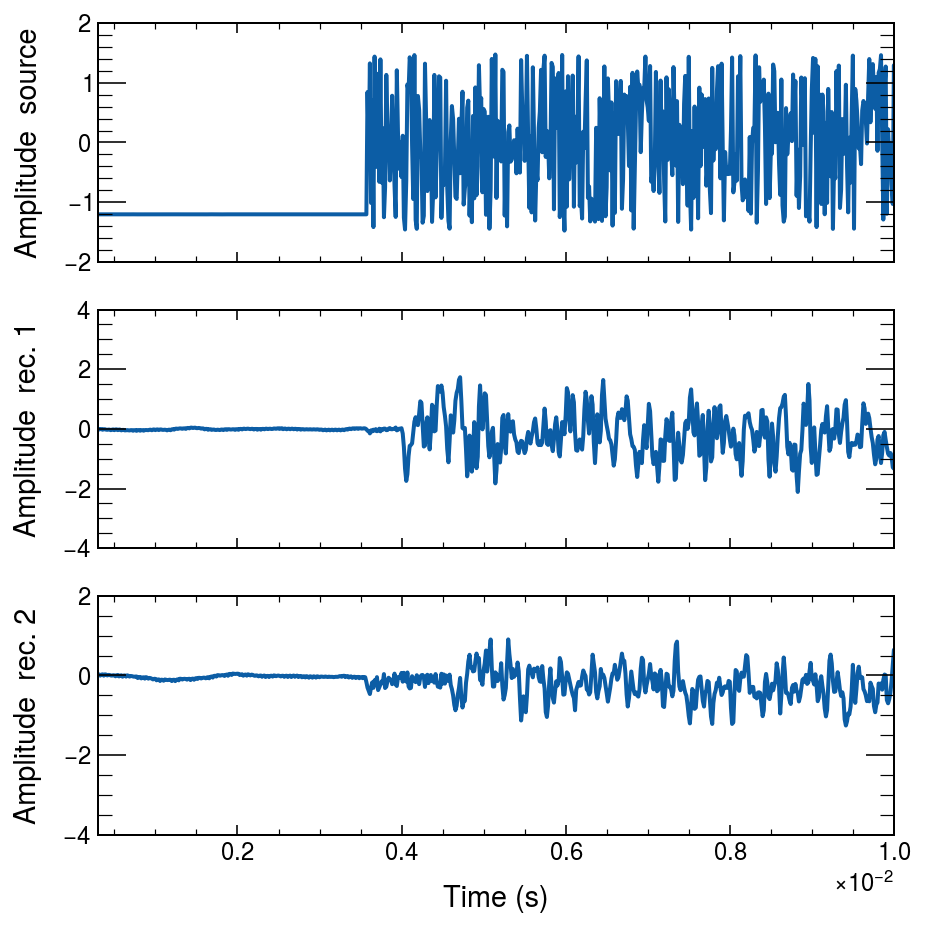

In [7]:
Data(files[0]).plot(0.0003, 0.01, True)

In [8]:
from scipy import fft
def signal_fft(data: Data):
    
    fft_data = FFTData(data)
    
    fft_data.source = 2.0/fft_data.samples * np.abs(fft.fft(fft_data.source, n=fft_data.samples)[:fft_data.samples//2])
    fft_data.receiver_1 = 2.0/fft_data.samples * np.abs(fft.fft(fft_data.receiver_1, n=fft_data.samples)[:fft_data.samples//2])
    fft_data.receiver_2 = 2.0/fft_data.samples * np.abs(fft.fft(fft_data.receiver_2, n=fft_data.samples)[:fft_data.samples//2])
    
    fft_data.time_clock = fft.fftfreq(fft_data.samples, 1/fft_data.freq_sampling)[:fft_data.samples//2]
    
    return fft_data

def response_function(data: Data):
    
    sfft = signal_fft(data)
    freq = sfft.time_clock
    H1 = 10 * np.log10(sfft.receiver_1/sfft.source)
    H2 = 10 * np.log10(sfft.receiver_2/sfft.source)
    
    plt.figure()
    hep.label.exp_text('L3 ', 'Preliminary')
    hep.label.lumitext(f'({data.name})')
    plt.plot(freq, H1, label='$H_1$ Transfer function (rec. 1)')
    plt.plot(freq, H2, label='$H_2$ Transfer function (rec. 2)')
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Gain $10\cdot\log|H|$ (dB)')
    plt.xlim(0, np.max(freq))
    plt.legend()

<AxesSubplot:xlabel='Frequency (Hz)', ylabel='FFT  rec. 2'>

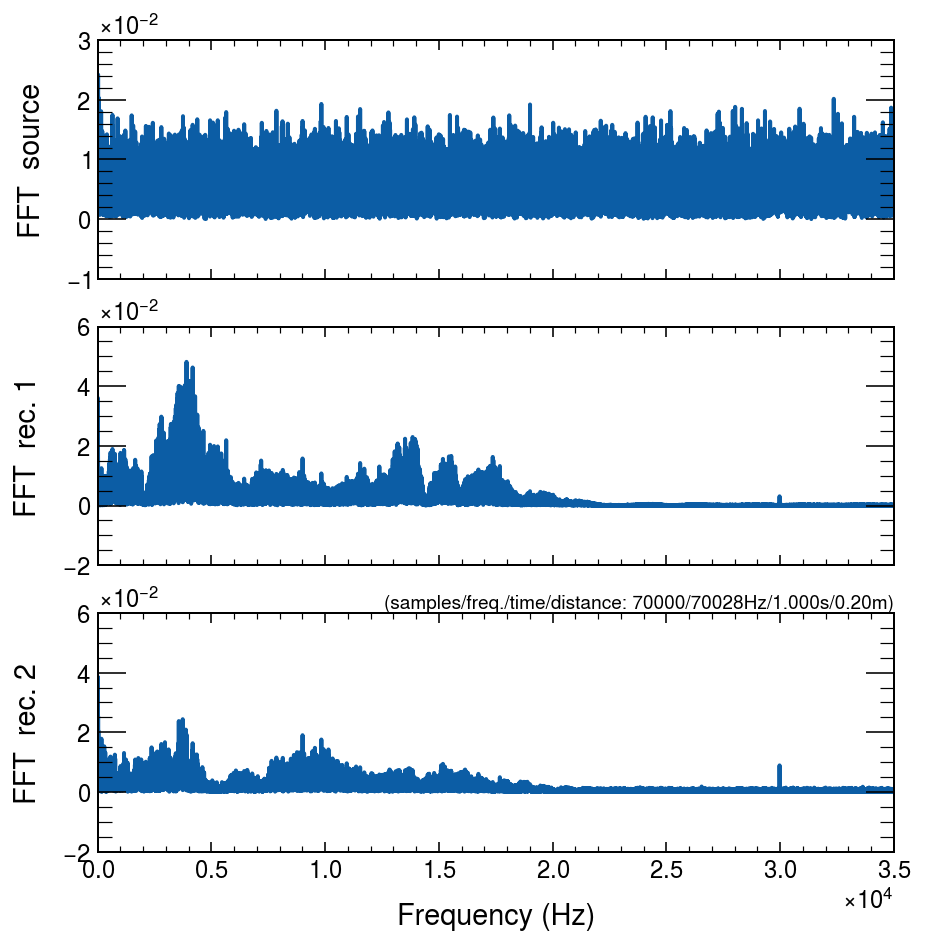

In [9]:
signal_fft(Data(files[0])).plot()
plt.xlim(0,3.5e4)
# hep.label.exp_text('L3 ', 'Preliminary')
hep.label.lumitext(f'({Data(files[0]).name})')

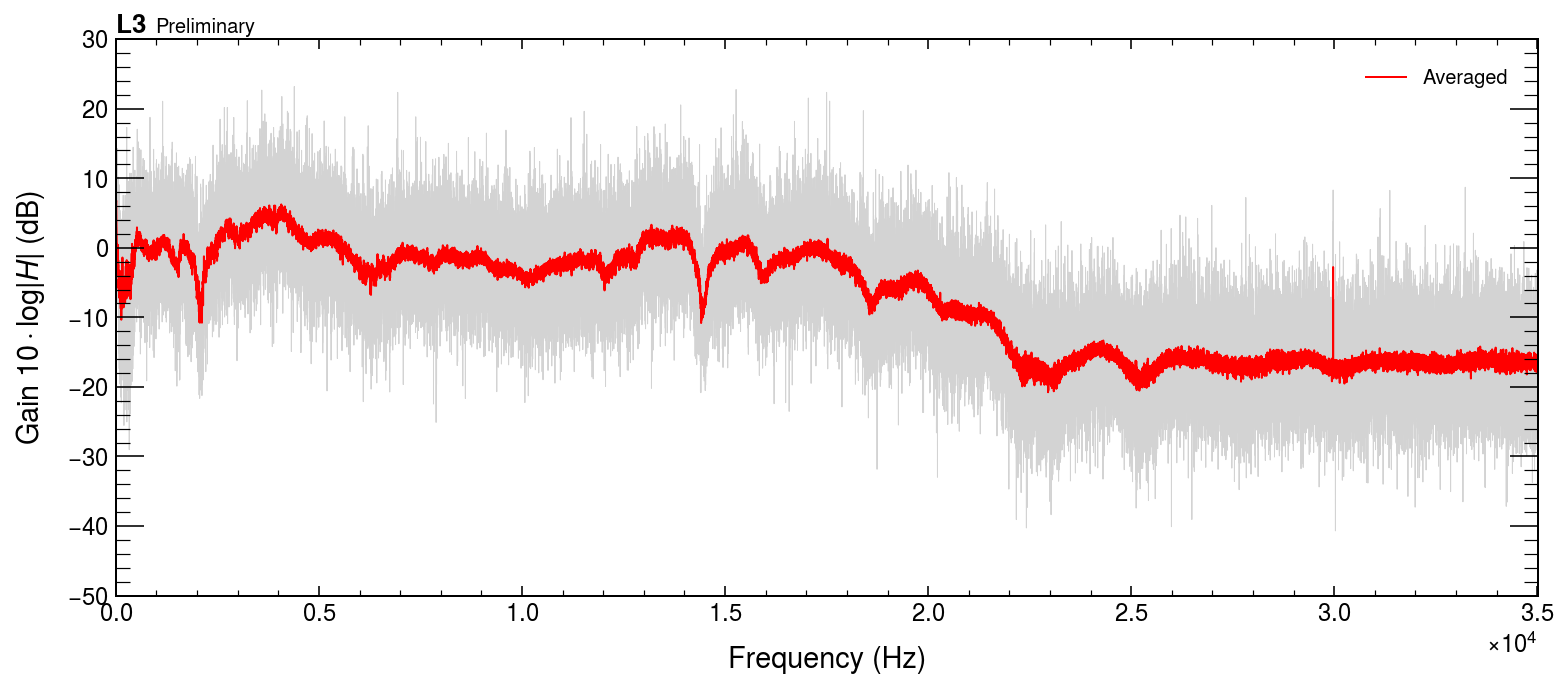

In [10]:

# Averaging over iterations, receiver_1 and source 
# to collect cleaner transfer function.

plt.figure(figsize=(12.5, 4.8))

freq_ffts = signal_fft(Data(files[0])).time_clock

source_ffts = np.array([signal_fft(Data(file)).source for file in files])
source_averaged_fft = source_ffts.mean(axis=0)
source_std_fft = source_ffts.std(axis=0)
rec1_ffts = np.array([signal_fft(Data(file)).receiver_1 for file in files])
rec1_averaged_fft = rec1_ffts.mean(axis=0)
rec1_std_fft = rec1_ffts.std(axis=0)

TF1_avg = rec1_averaged_fft / source_averaged_fft

for sfft, rfft in zip(source_ffts, rec1_ffts):
    plt.plot(freq_ffts, 10 * np.log10(rfft / sfft), 'lightgray', lw=0.5)

hep.label.exp_text('L3 ', 'Preliminary')
# hep.label.lumitext(f'({data.name})')
plt.plot(freq_ffts, 10 * np.log10(TF1_avg), 'r', label='Averaged', lw=1)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Gain $10\cdot\log|H|$ (dB)')
plt.xlim(0, np.max(freq_ffts))
plt.legend()

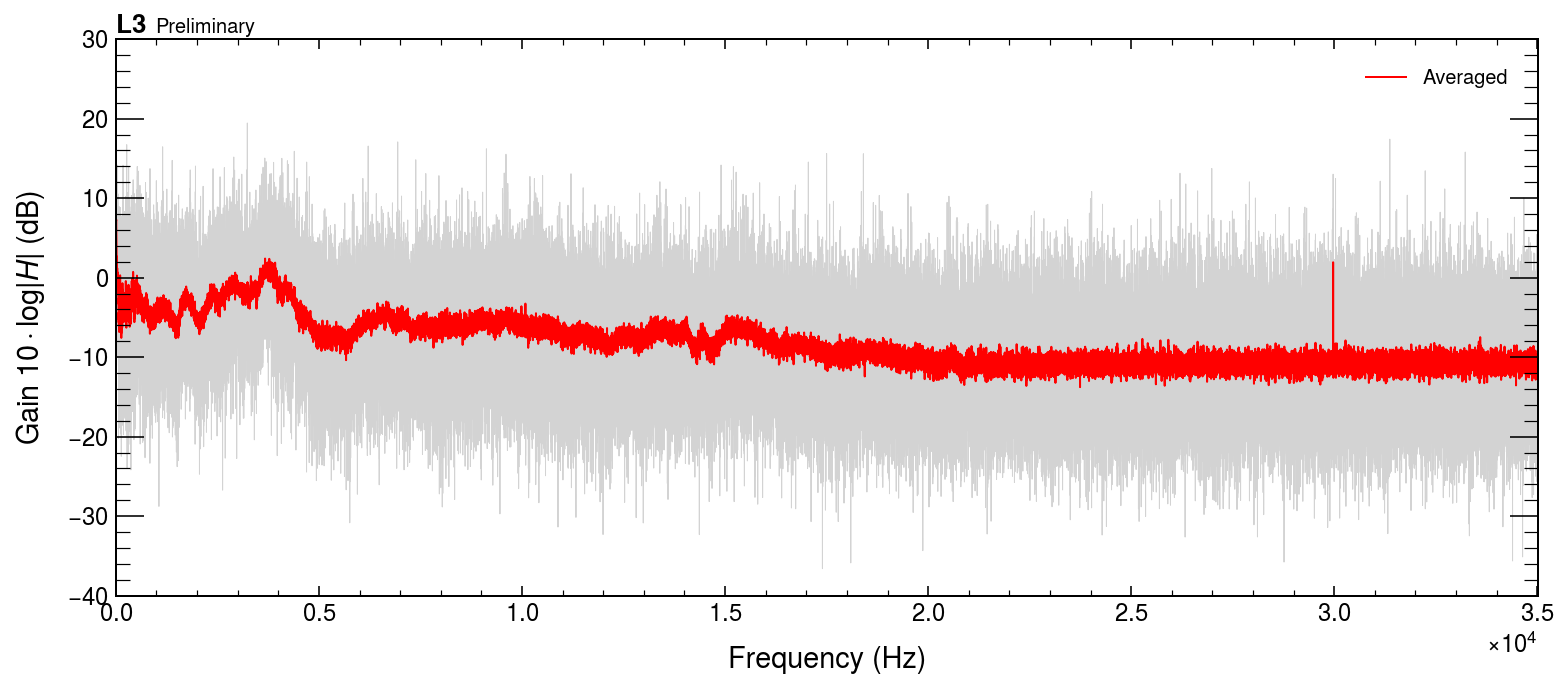

In [11]:
plt.figure(figsize=(12.5, 4.8))
rec2_ffts = np.array([signal_fft(Data(file)).receiver_2 for file in files])
rec2_averaged_fft = rec2_ffts.mean(axis=0)
rec2_std_fft = rec2_ffts.std(axis=0)
for sfft, rfft in zip(source_ffts, rec2_ffts):
    plt.plot(freq_ffts, 10 * np.log10(rfft / sfft), 'lightgray', lw=0.5)

TF2_avg = rec2_averaged_fft / source_averaged_fft
hep.label.exp_text('L3 ', 'Preliminary')
# hep.label.lumitext(f'({data.name})')
plt.plot(freq_ffts, 10 * np.log10(TF2_avg), 'r', label='Averaged', lw=1)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Gain $10\cdot\log|H|$ (dB)')
plt.xlim(0, np.max(freq_ffts))
plt.legend()

While computing the mean over the 0th-axis, the second receiver got moved from iths initial position so FFT Amplitude is not valid data, hence we can't have accurate frequency response for the amplifier/receiver system. 

## Cross/Auto correlation: computing S.o.S.

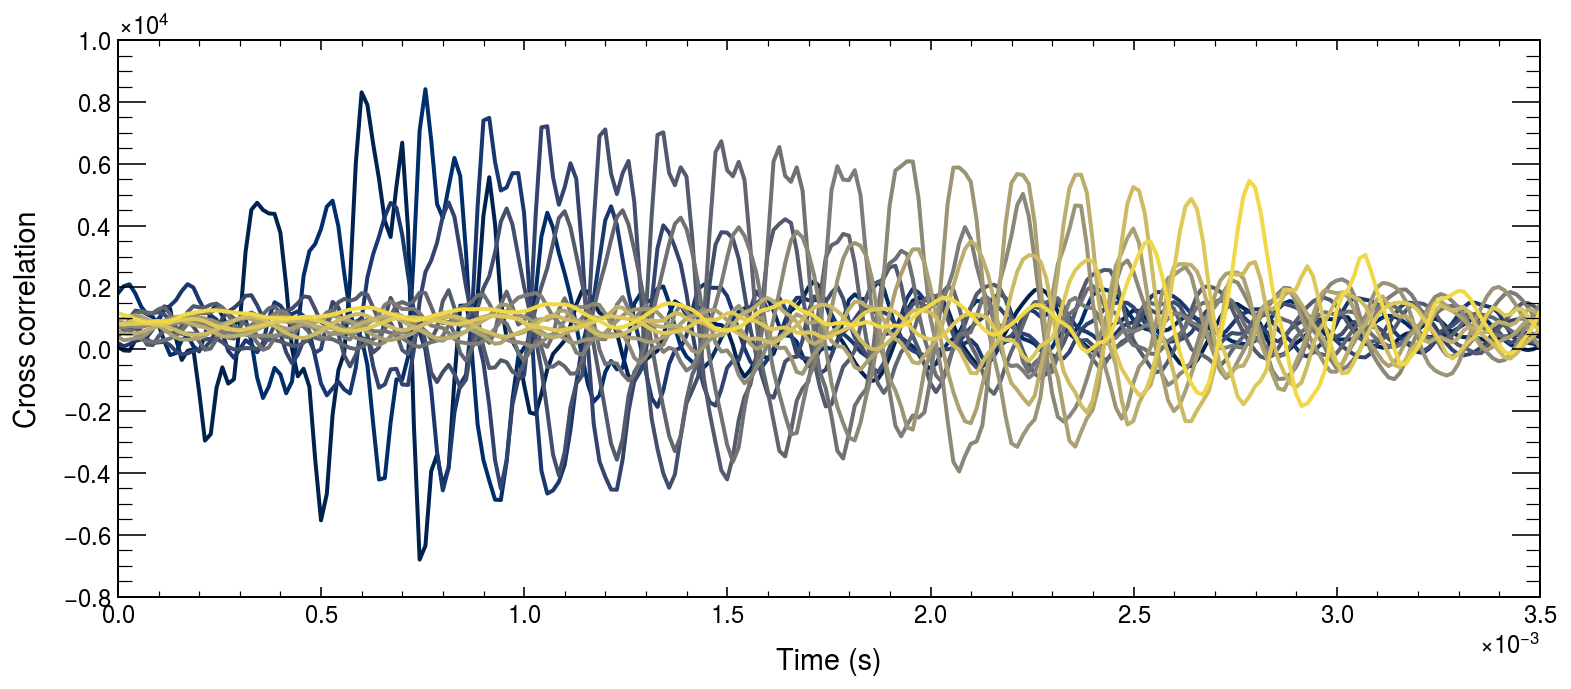

In [12]:

## Cross-Correlation and auto correlation: 

from scipy import signal

plt.figure(figsize=(12.5, 4.8))
colors = plt.cm.cividis

delays = np.zeros_like(files, dtype=float)
distances = np.zeros_like(files, dtype=float)

for idx, d in enumerate([Data(file) for file in files]):
    cc_r12 = signal.correlate(d.receiver_2, d.receiver_1)
    lag = signal.correlation_lags(d.samples, d.samples) * 1/d.freq_sampling
    delays[idx] = float(lag[np.argmax(cc_r12)])
    distances[idx] = float(d.distance)
    plt.plot(lag, cc_r12, label=f'{d.name}', color=colors(idx/len(files)))
    plt.xlim(0, 0.0035)
    plt.xlabel('Time (s)')
    plt.ylabel('Cross correlation')
    # plt.legend(loc=(1,0.1))



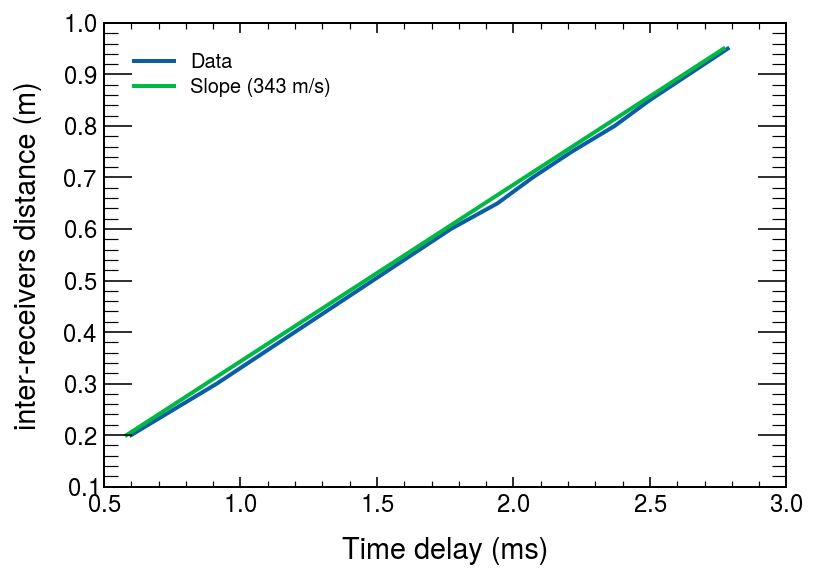

In [8]:
plt.plot(delays * 1e3, distances, label='Data')
plt.plot(distances / 343 * 1e3, distances, label='Slope (343 m/s)')
plt.xlabel('Time delay (ms)')
plt.ylabel('inter-receivers distance (m)')
plt.legend()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 1.258 (chi2/ndof = 0.1)    │              Nfcn = 48               │
│ EDM = 8.73e-07 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬──────

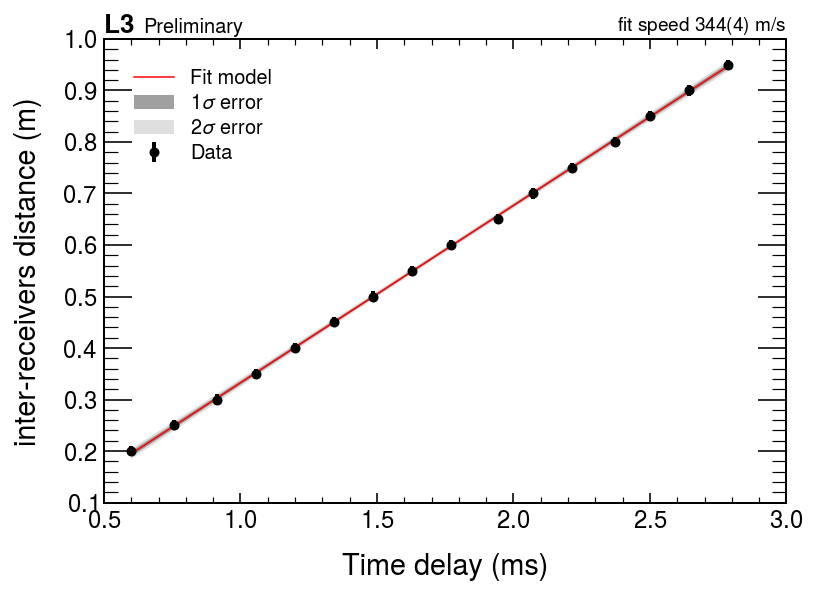

In [13]:

## Fit and errors

error_distance = 0.01 ## 15 mm acccounting for parallax and various errors

from iminuit import Minuit
from iminuit.cost import LeastSquares

from jacobi import propagate
from uncertainties import ufloat

def model(x, p):
    return x * p[0] + p[1]

fnc = LeastSquares(delays, distances, error_distance, model)
fnc.loss = 'soft_l1'
m = Minuit(fnc, (343, 0))
m.migrad()
print(m)

y, ycov = propagate(lambda p: model(delays, p), m.values, m.covariance)
yerr_prop = np.diag(ycov) ** 0.5

plt.errorbar(delays * 1e3, distances, yerr=error_distance, fmt='k.', label='Data')
plt.plot(delays * 1e3, model(delays, m.values), 'r', label='Fit model', lw=0.75)


plt.fill_between(delays * 1e3, y+yerr_prop, y-yerr_prop, facecolor='gray', alpha=0.75, label='1$\sigma$ error')
plt.fill_between(delays * 1e3, y+2*yerr_prop, y-2*yerr_prop, facecolor='gray', alpha=0.25, label='2$\sigma$ error')
plt.xlabel('Time delay (ms)')
plt.ylabel('inter-receivers distance (m)')
hep.label.exp_text('L3 ', 'Preliminary')
hep.label.lumitext(f'fit speed ${ufloat(m.values[0], m.errors[0]):.uSL}$ m/s')
plt.legend()
plt.savefig('plot.pdf', bbox_inches='tight')